<ipython-input-11-95e85de3d39c>:24: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


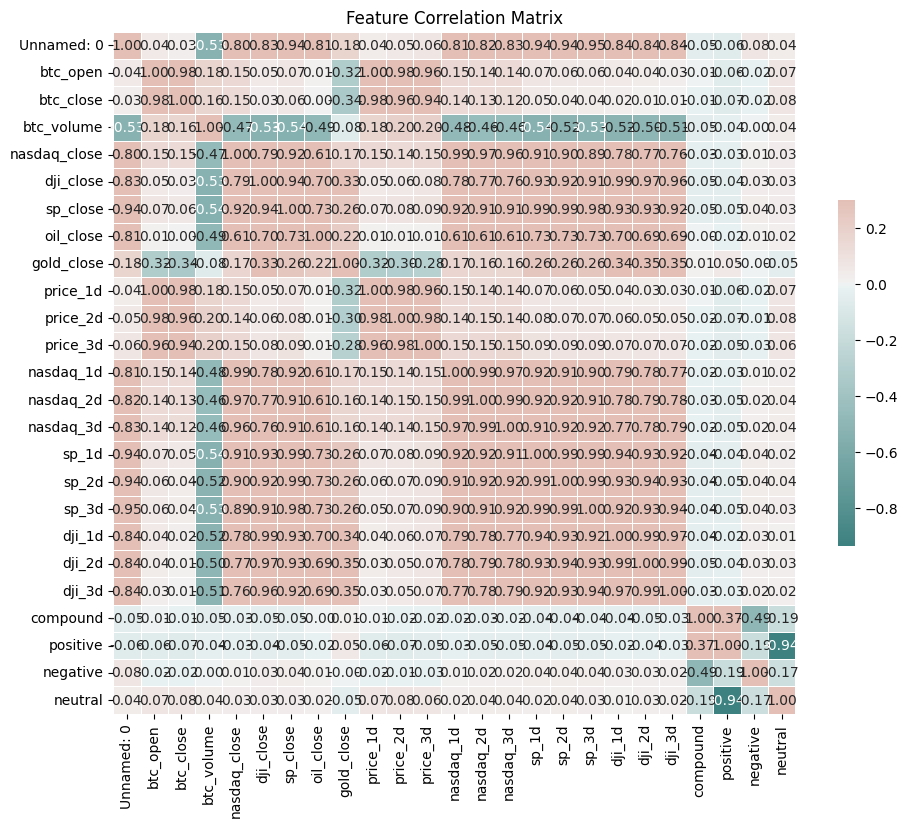

   Unnamed: 0      btc_open     btc_close    btc_volume  nasdaq_close  \
0           2  37475.105469  36926.066406   68838074392  13777.740234   
1           3  36931.546875  38144.308594   58598066402  13856.299805   
2           4  38138.386719  39266.011719   71326033653  13987.639648   
3           5  39250.191406  38903.441406   65500641143  13987.639648   
4           6  38886.828125  46196.464844  101467222687  13987.639648   

      dji_close     sp_close  oil_close   gold_close      price_1d  ...  \
0  31055.900391  3871.739990  56.230000  1788.900024  37472.089844  ...   
1  31148.199219  3886.830078  56.849998  1810.900024  36926.066406  ...   
2  31385.800781  3915.590088  57.970001  1831.900024  38144.308594  ...   
3  31385.800781  3915.590088  57.970001  1831.900024  39266.011719  ...   
4  31385.800781  3915.590088  57.970001  1831.900024  38903.441406  ...   

         sp_2d        sp_3d        dji_1d        dji_2d        dji_3d  \
0  3826.310059  3773.860107  30723.59

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# import dataset
data = pd.read_csv('stock_polarity_ver2.csv')

"""
Correlation matrix for feature selection

"""

corr = data.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(550, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

ax.set_title('Feature Correlation Matrix')
plt.show()

# Calculate the return rate
data['return'] = data['btc_close']

data.to_csv('/return_polarity.csv')
data.dropna(inplace=True)
data.drop("date",axis=1,inplace=True)

print(data.head(5))


"""
Selecting features and target

"""
# baseline

x = data[['btc_volume', 'nasdaq_close','dji_close','sp_close', 'oil_close', 'gold_close']]
y = data['return']
# situation 1: add polarity score as one of the predictors
x_1 = data[['btc_volume', 'nasdaq_close','dji_close','sp_close', 'oil_close', 'gold_close','compound']]

"""
Data partition

"""
# baseline
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
print('Data Split for baseline done.')

# situation 1: add polarity score as one of the predictors
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_1, y, test_size=0.20, random_state=0)
print('Data Split for situation 1 done.')


"""
Prediction models - Training

"""
# Linear Regression

linear_model = LinearRegression()
linear_model.fit(x_train, y_train) # -------- baseline

linear_model1 = LinearRegression()
linear_model1.fit(x_train1, y_train1) # -------- situation 1


# Random Forest
# Defining the parameter grid for tuning the Random Forest Regressor
param_grid_rf = {
    'n_estimators': [100, 500, 1000],
    'max_depth':[None, 5, 10],
    'min_samples_split': [5, 10]
}

# Initializing GridSearchCV for the baseline model (Random Forest)
grid_search_rf_baseline = GridSearchCV(RandomForestRegressor(random_state=0), param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf_baseline.fit(x_train, y_train)
# Best parameters and score for the baseline model (Random Forest)
best_params_rf_baseline = grid_search_rf_baseline.best_params_
rf_model = RandomForestRegressor(**best_params_rf_baseline, random_state=0)
rf_model.fit(x_train, y_train)

# Initializing GridSearchCV for situation 1 model (Random Forest)
grid_search_rf_situation1 = GridSearchCV(RandomForestRegressor(random_state=0), param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf_situation1.fit(x_train1, y_train1)

# Best parameters and score for situation 1 model (Random Forest)
best_params_rf_situation1 = grid_search_rf_situation1.best_params_
rf_model1 = RandomForestRegressor(**best_params_rf_situation1, random_state=0)
rf_model1.fit(x_train1, y_train1)

# XGBoost
xgb_model_baseline = XGBRegressor(n_estimators=100, random_state=0)
xgb_model_baseline.fit(x_train, y_train)  # Fit XGBoost on the baseline data


xgb_model_situation1 = XGBRegressor(n_estimators=100, random_state=0)
xgb_model_situation1.fit(x_train1, y_train1)  # Fit XGBoost on situation 1 data


"""
Prediction models - Testing (making prediction)

"""
# Linear Regression
linear_pred = linear_model.predict(x_test) # -------- baseline
linear_pred1 = linear_model1.predict(x_test1) # -------- situation 1


# Random Forest Regression
rf_pred = rf_model.predict(x_test)
rf_pred1 = rf_model1.predict(x_test1)

# XGBoost
xgb_pred_baseline = xgb_model_baseline.predict(x_test)  # Make predictions on the test data
xgb_pred_situation1 = xgb_model_situation1.predict(x_test1)  # Make predictions on the test data for situation 1

#
"""
Model Evaluation - test RMSE, R2 Score

"""

# Creating a DataFrame to print out the results
model_results = {
    ('Linear Regression', 'Baseline'): {'RMSE': np.sqrt(mean_squared_error(y_test, linear_pred)),
                                        'R2 Score': r2_score(y_test, linear_pred)},
    ('Linear Regression', 'Situation1'): {'RMSE': np.sqrt(mean_squared_error(y_test1, linear_pred1)),
                                          'R2 Score': r2_score(y_test1, linear_pred1)},
    ('Random Forest', 'Baseline'): {'RMSE': np.sqrt(mean_squared_error(y_test, rf_pred)),
                                       'R2 Score': r2_score(y_test, rf_pred)},
    ('Random Forest', 'Situation1'): {'RMSE': np.sqrt(mean_squared_error(y_test1, rf_pred1)),
                                         'R2 Score': r2_score(y_test1, rf_pred1)},
    ('XGBoost', 'Baseline'): {'RMSE': np.sqrt(mean_squared_error(y_test, xgb_pred_baseline)),
                              'R2 Score': r2_score(y_test, xgb_pred_baseline)},
    ('XGBoost', 'Situation1'): {'RMSE': np.sqrt(mean_squared_error(y_test1, xgb_pred_situation1)),
                                'R2 Score': r2_score(y_test1, xgb_pred_situation1)}
}

# Create a MultiIndex DataFrame
model_results_df = pd.DataFrame(model_results)

# Optional: Round the values for readability
model_results_df = model_results_df.round(5)

print(model_results_df)



## **TS models**

In [ ]:




from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Sensitivity analysis: see if time series model performs better than regular ML models
ts_data = stock_bayes[['date', 'btc_close','dji_close','nasdaq_close','oil_close','sp_close','sentiment']]
ts_data['date'] = pd.to_datetime(ts_data['date'])
# change sentiment to dummy variable
ts_data['sentiment'] = ts_data['sentiment'].replace({'negative': 0, 'positive': 1})
ts_data

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pandas as pd
import numpy as np


# Prepare data
features = ts_data[['dji_close', 'nasdaq_close', 'oil_close', 'sp_close', 'sentiment']]  # Features
target = ts_data['btc_close']  # Target

# Scaling the data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(np.array(target).reshape(-1, 1))

# Splitting the data
train_size = int(len(scaled_features) * 0.8)
train_features, test_features = scaled_features[:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[:train_size], scaled_target[train_size:]

# Reshape data for LSTM
train_features = np.reshape(train_features, (train_features.shape[0], train_features.shape[1], 1))
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

# LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(train_features.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Training the LSTM model
model_lstm.fit(train_features, train_target, epochs=100, batch_size=32, verbose=1)

# Predictions
predictions_lstm = model_lstm.predict(test_features)

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming time series data is sorted by date
ts_data.set_index('date', inplace=True)

# Splitting the data
train_size = int(len(ts_data) * 0.8)
train_data, test_data = ts_data.iloc[:train_size], ts_data.iloc[train_size:]

# ARIMA model
model_arima = ARIMA(train_data['btc_close'], order=(5, 1, 0))
model_fit_arima = model_arima.fit()
predictions_arima = model_fit_arima.forecast(steps=len(test_data))

# SARIMA model
model_sarima = SARIMAX(train_data['btc_close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit_sarima = model_sarima.fit()
predictions_sarima = model_fit_sarima.forecast(steps=len(test_data))


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Gradient Boosting Regressor model
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_regressor.fit(X_train, y_train)

# Predictions
predictions_gb = gb_regressor.predict(X_test)


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# LSTM Model Evaluation
mse_lstm = mean_squared_error(test_target, predictions_lstm)
mae_lstm = mean_absolute_error(test_target, predictions_lstm)
r2_lstm = r2_score(test_target, predictions_lstm)

# ARIMA and SARIMA Evaluation
mse_arima = mean_squared_error(test_data['btc_close'], predictions_arima)
mae_arima = mean_absolute_error(test_data['btc_close'], predictions_arima)
r2_arima = r2_score(test_data['btc_close'], predictions_arima)

mse_sarima = mean_squared_error(test_data['btc_close'], predictions_sarima)
mae_sarima = mean_absolute_error(test_data['btc_close'], predictions_sarima)
r2_sarima = r2_score(test_data['btc_close'], predictions_sarima)

# Gradient Boosting Regressor Evaluation
mse_gb = mean_squared_error(y_test, predictions_gb)
mae_gb = mean_absolute_error(y_test, predictions_gb)
r2_gb = r2_score(y_test, predictions_gb)

# Print metrics for each model
print("LSTM Model Metrics:")
print(f"MSE: {mse_lstm}, MAE: {mae_lstm}, R2: {r2_lstm}")
print("\nARIMA Model Metrics:")
print(f"MSE: {mse_arima}, MAE: {mae_arima}, R2: {r2_arima}")
print("\nSARIMA Model Metrics:")
print(f"MSE: {mse_sarima}, MAE: {mae_sarima}, R2: {r2_sarima}")
print("\nGradient Boosting Regressor Metrics:")
print(f"MSE: {mse_gb}, MAE: {mae_gb}, R2: {r2_gb}")